In [189]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import CubicSpline

In [190]:
class IsingModel:
    def __init__(self, L, T):
        #parametros do modelo
        self.L = L
        self.T = T

        #array com os spins
        self.spins = np.ones((L,L))

        #arrays para guardar evoluções das variáveis
        self.energies= []
        self.magnetizations= [-L**2]

        #energia e magnetização total
        self.energy_total = self.calc_ener_total()
        self.magnet_total = np.sum(self.spins)

    def calc_ener_spin(self, i, j):
        #calcular a energia de um spin
        spin= self.spins[i,j]
        neighbours= (
        self.spins[(i+1)%self.L, j] + 
        self.spins[i, (j+1)%self.L] + 
        self.spins[(i-1)%self.L, j] + 
        self.spins[i, (j-1)%self.L]
        )
        energy=-spin*neighbours
        return energy
    
    def calc_ener_total( self ):
        energy=0
        for i in range(self.L):
            for j in range(self.L):
                energy+= -self.spins[i,j]*(self.spins[(i+1)%self.L,j]+ self.spins[i,(j+1)%self.L])
        return energy
    
    def calc_ener ( self ):
        energy=self.energy_total/self.L**2

        return energy
    
    def calc_mag( self ):
        mag = self.magnet_total
        return mag
    

    def iter_monte_carlo(self,n_iter):

        #calcular a energia do sistema inicialmente
        E = self.calc_ener_total()
        self.energies.append(E)

        #iterar com o método de Metropolis Hastings
        for _ in tqdm(range(n_iter), desc=f"L={self.L:6d},T={self.T:8f}"):
            #proposal: spin flip
            i = np.random.randint(0, self.L)
            j = np.random.randint(0, self.L)
            prop = self.spins
            prop[i, j] = -prop[i, j]

            #calculate acceptance probability
            Delta_E = -2*self.calc_ener_spin(i, j)
            Delta_Mag = -2*self.spins[i,j]
            R = np.exp(-Delta_E/(self.T))
            
            u = np.random.uniform(0, 1)
            if R > u:
                self.spins = prop
                E += Delta_E
                Mag = self.magnet_total + Delta_Mag

            self.energies.append(E)
            self.magnetizations.append(Mag)
    
    @property
    def energy(self):
        return np.array(self.energies)
    


## 1. Tempo de Termalização

**a)** O código corre uma simulação para cada combinação de L e T e dá plot no gráfico da energia média.

L=    16,T=1.000000: 0it [00:00, ?it/s]
L=    16,T=1.000000: 100%|██████████| 9/9 [00:00<00:00, 54471.48it/s]


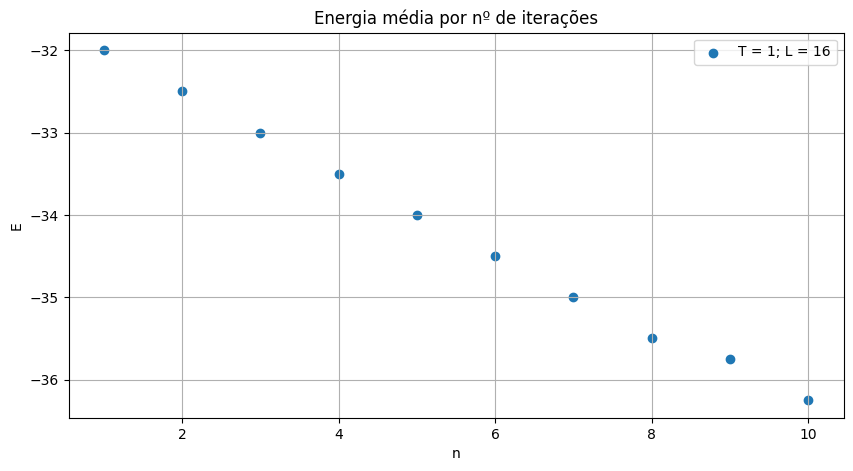

L=    16,T=2.000000: 0it [00:00, ?it/s]
L=    16,T=2.000000: 100%|██████████| 9/9 [00:00<00:00, 112682.79it/s]


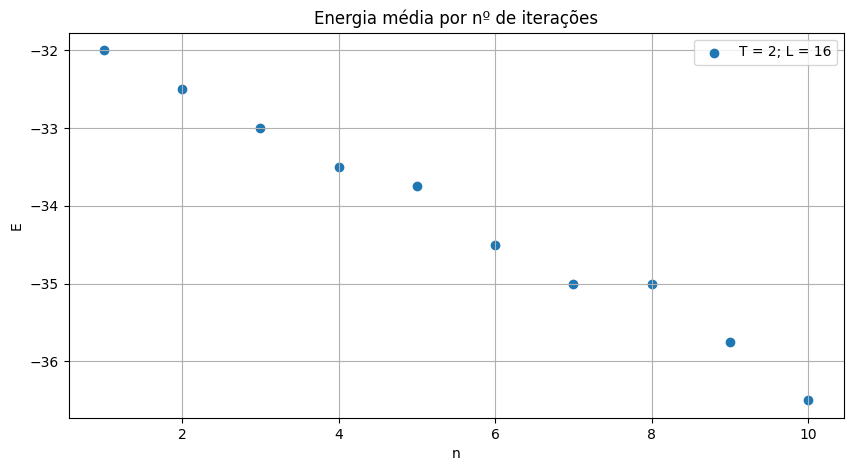

L=    16,T=3.000000: 0it [00:00, ?it/s]
L=    16,T=3.000000: 100%|██████████| 9/9 [00:00<00:00, 115439.56it/s]


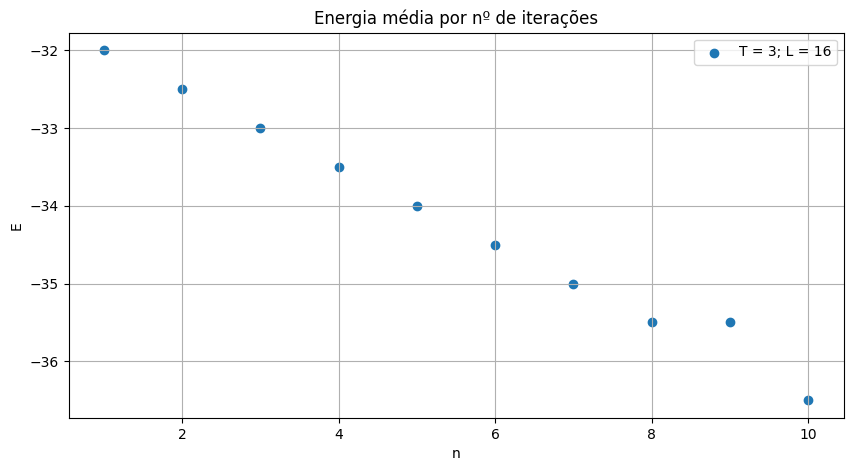

L=    16,T=4.000000: 0it [00:00, ?it/s]
L=    16,T=4.000000: 100%|██████████| 9/9 [00:00<00:00, 69391.06it/s]


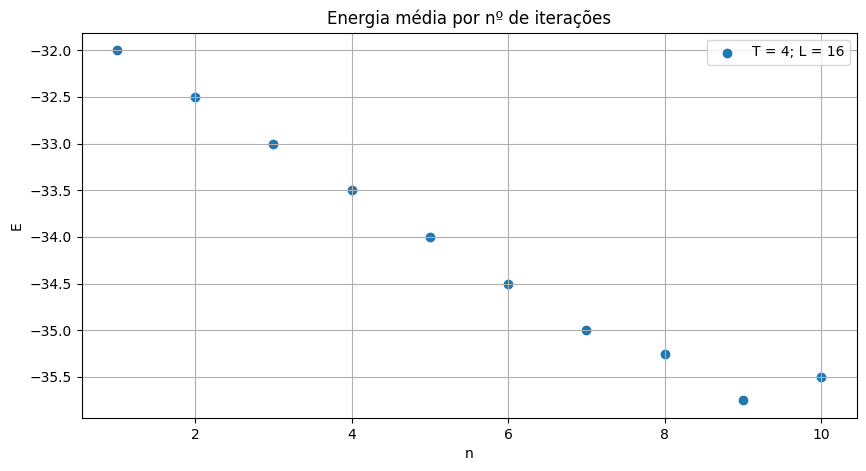

L=    32,T=1.000000: 0it [00:00, ?it/s]
L=    32,T=1.000000: 100%|██████████| 9/9 [00:00<00:00, 64749.12it/s]


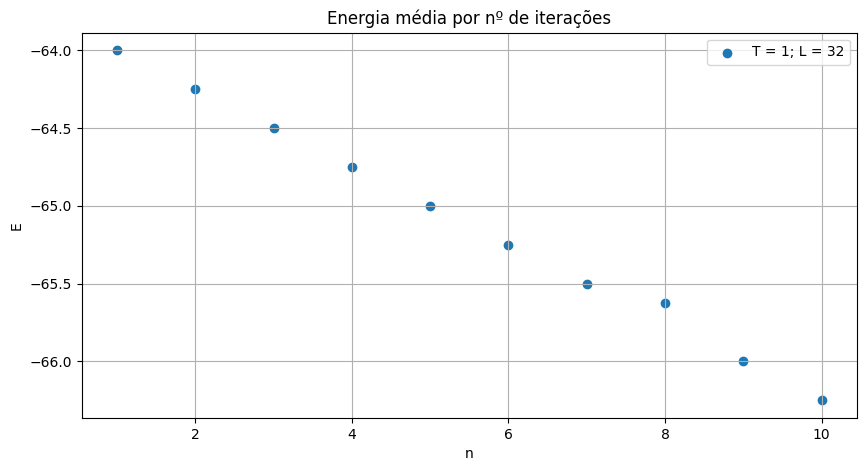

L=    32,T=2.000000: 0it [00:00, ?it/s]
L=    32,T=2.000000: 100%|██████████| 9/9 [00:00<00:00, 46660.98it/s]


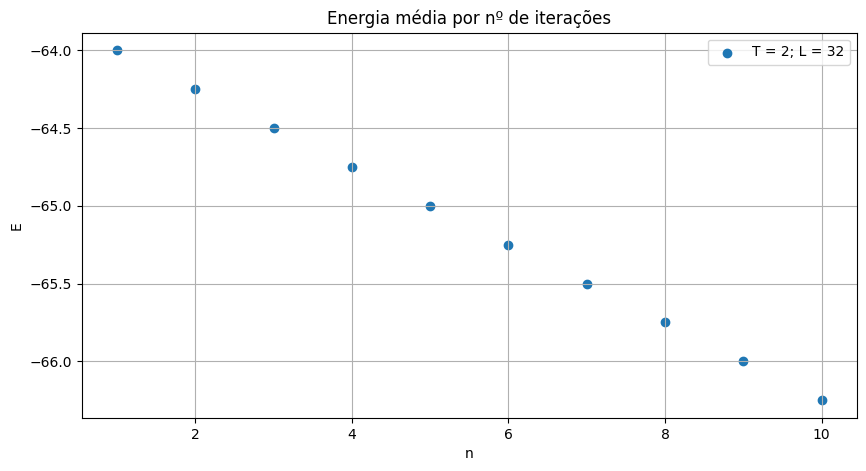

L=    32,T=3.000000: 0it [00:00, ?it/s]
L=    32,T=3.000000: 100%|██████████| 9/9 [00:00<00:00, 104567.14it/s]


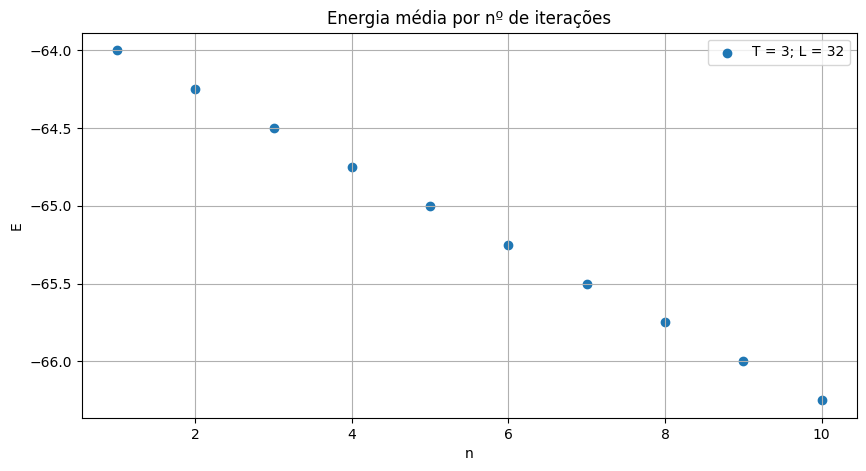

L=    32,T=4.000000: 0it [00:00, ?it/s]
L=    32,T=4.000000: 100%|██████████| 9/9 [00:00<00:00, 110054.62it/s]


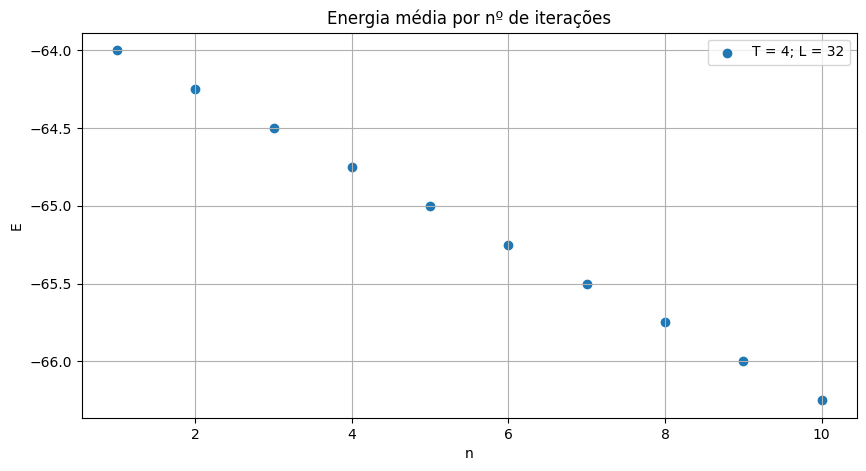

L=    64,T=1.000000: 0it [00:00, ?it/s]
L=    64,T=1.000000: 100%|██████████| 9/9 [00:00<00:00, 79638.68it/s]


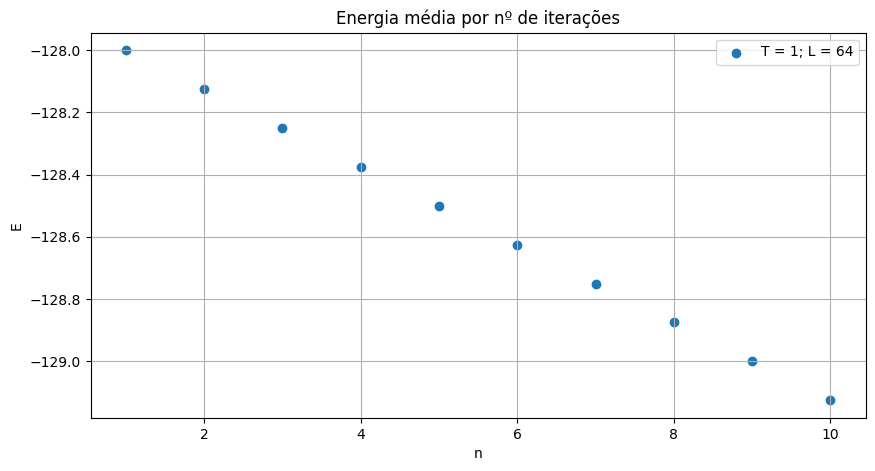

L=    64,T=2.000000: 0it [00:00, ?it/s]
L=    64,T=2.000000: 100%|██████████| 9/9 [00:00<00:00, 101203.05it/s]


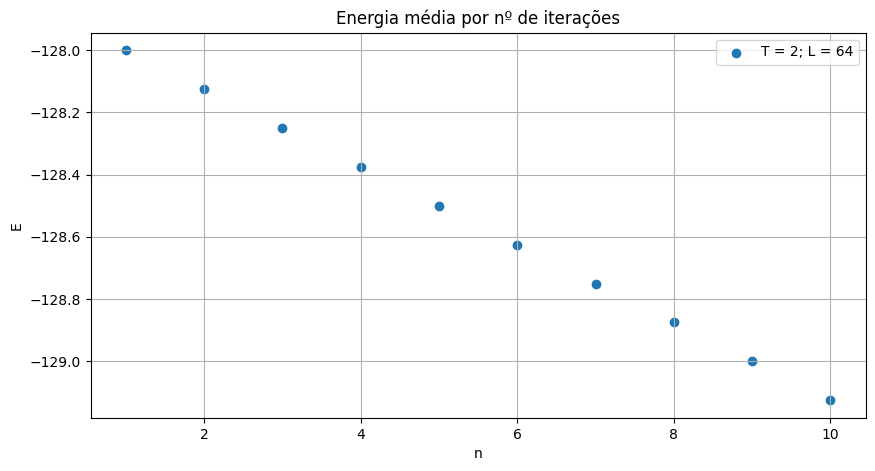

L=    64,T=3.000000: 0it [00:00, ?it/s]
L=    64,T=3.000000: 100%|██████████| 9/9 [00:00<00:00, 84638.42it/s]


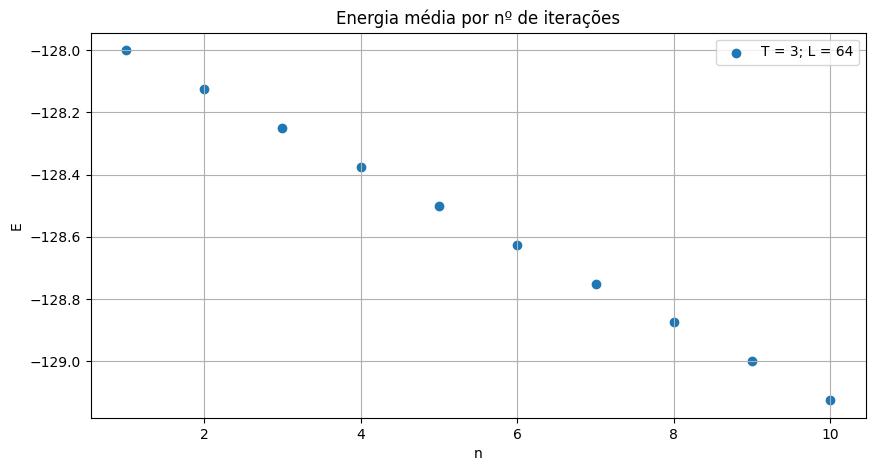

L=    64,T=4.000000: 0it [00:00, ?it/s]
L=    64,T=4.000000: 100%|██████████| 9/9 [00:00<00:00, 93669.32it/s]


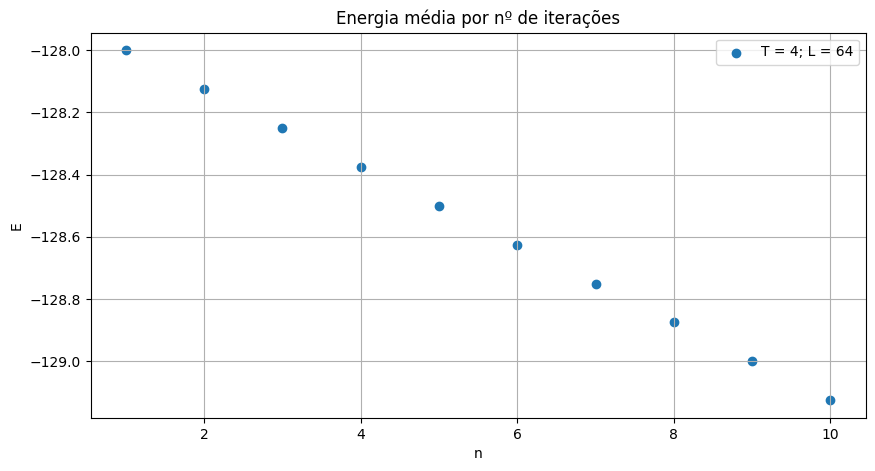

L=   128,T=1.000000: 0it [00:00, ?it/s]
L=   128,T=1.000000: 100%|██████████| 9/9 [00:00<00:00, 76260.07it/s]


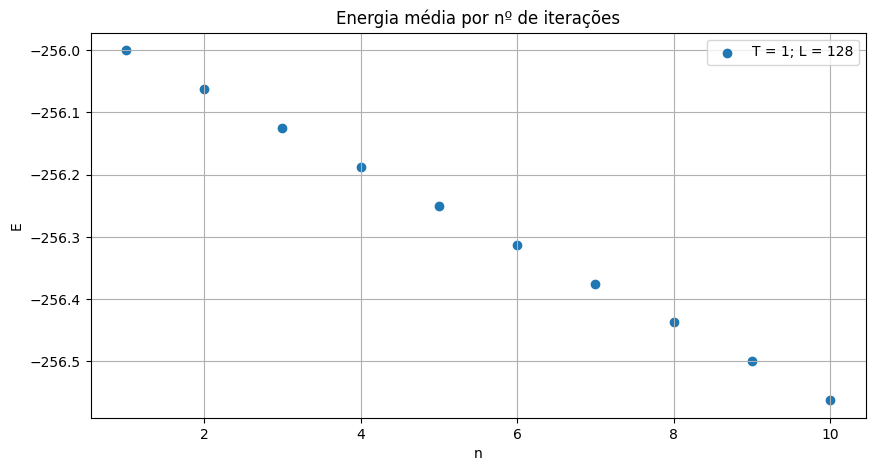

L=   128,T=2.000000: 0it [00:00, ?it/s]
L=   128,T=2.000000: 100%|██████████| 9/9 [00:00<00:00, 81180.08it/s]


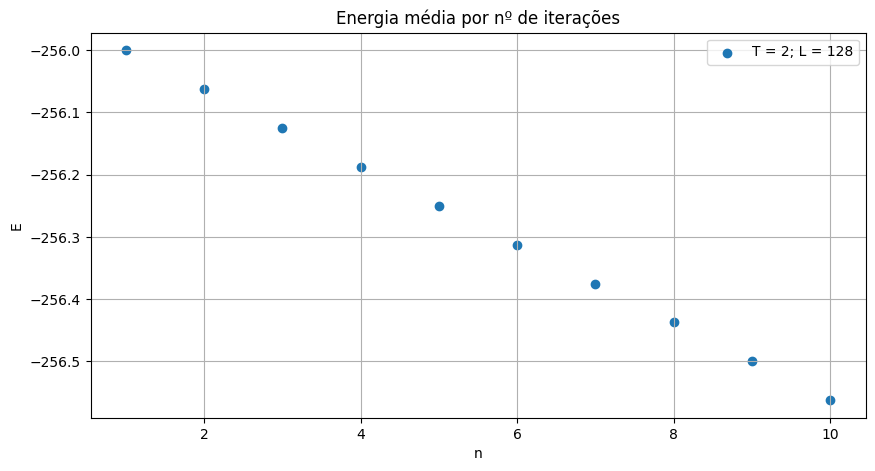

L=   128,T=3.000000: 0it [00:00, ?it/s]
L=   128,T=3.000000: 100%|██████████| 9/9 [00:00<00:00, 76881.34it/s]


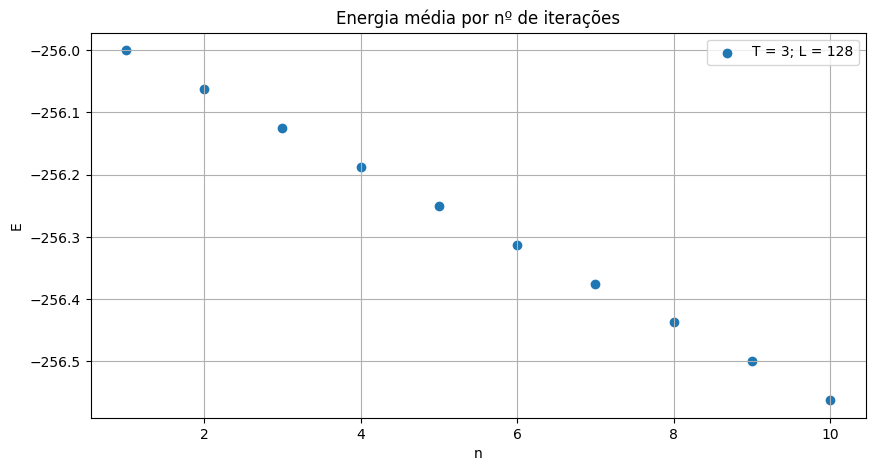

L=   128,T=4.000000: 0it [00:00, ?it/s]
L=   128,T=4.000000: 100%|██████████| 9/9 [00:00<00:00, 78972.25it/s]


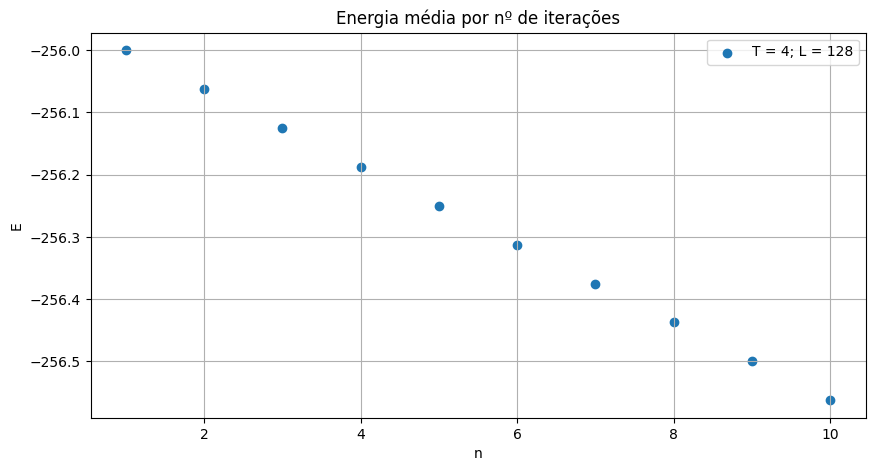

In [191]:
L_array = [16, 32, 64, 128]
T_array = [1, 2, 3, 4]
n_iter = np.arange(1, 11, 1)

#for L in L_array:

for L in L_array:
    for T in T_array:
        ener_array = np.zeros(10)
        for n in range(10):
            ising = IsingModel(L, T)
            ising.iter_monte_carlo(n) #Correr a simulação para cada n_iter
            #print(ising.energies)
            avg_ener = ising.energies[-1]/L #Energia média
            #print(avg_ener)
            ener_array[n] = avg_ener

        #print(ener_array)

        plt.figure(figsize=(10, 5))    
        plt.scatter(n_iter, ener_array, label=f'T = {T}; L = {L}')
        plt.title('Energia média por nº de iterações') 
        plt.xlabel('n') 
        plt.ylabel('E') 
        plt.legend() 
        plt.grid() 
        plt.show()

**b)** Fit

In [192]:
def ener_func(N, e0, ef, tau):
    return ef + (e0 - ef) * np.exp(- N/tau)

vars = [curve_fit(ener_func, n_iter, ener_array[i]) for i in range(4)]

/var/folders/95/nwjkc2t962bbd0wkb2vkccbc0000gn/T/ipykernel_20427/1276039780.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  vars = [curve_fit(ener_func, n_iter, ener_array[i]) for i in range(4)]


AttributeError: 'tuple' object has no attribute 'ndim'

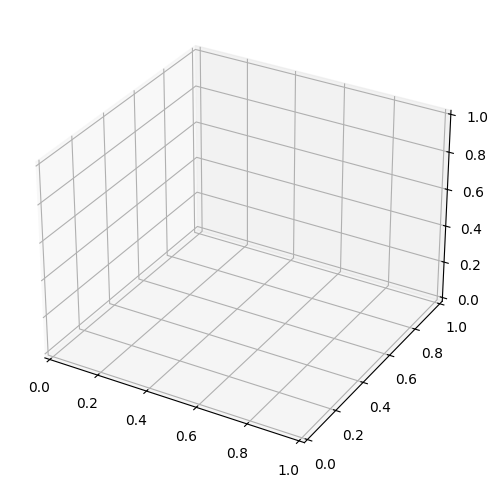

In [193]:
taus = vars[2]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(L, T, taus, cmap='viridis', edgecolor='none')
ax.set_xlabel('L')
ax.set_ylabel('T')
ax.set_zlabel(r'$\tau_{term}$')
ax.set_title('Intensidade da Luz em Função de X e Y')
plt.show() # mostrando o gráfico


## 2. Determinação da Temperatura Crítica

In [ ]:
L = 16
T = np.arange(1, 4.2, 0.2)

for t in T:
    critical_ising = IsingModel(L, t)
    critical_ising.iter_monte_carlo(1_000_000)
    quant = avg_ener

## 3. Determinação da Energia Livre de Helmholtz, F